# Kaggle: MNIST Challenge
## Coded by Daniel Wilcox

This is a notebook showing the process in predicting hand written digits 0-9.

In [1]:
#Misc.
import os
import random
import sys
import math
import glob
import re

#Dataframs and Arrays
import pandas as pd
import numpy as np

#Graphics
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

#Data Augmentation
from scipy.ndimage.interpolation import shift, rotate, map_coordinates, zoom

#Dataset manipulation
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

#Classifier Models:
import tensorflow as tf


In [2]:
#The Location of dataset (Train and Test data):
MNIST_PATH = "datasets/MNIST_Kaggle"

#The Location of saved models:
MODEL_PATH = "datasets/MNIST_Kaggle/Models"

#The Location of submission csv's:
SUBMISSION_PATH = "datasets/MNIST_Kaggle/Submissions" 

#CSV titles of Train and Test data:
train_name = "train.csv" 
test_name = "test.csv"

In [3]:
#Getting MNIST data from csv files

def load_MNIST_data(file_name, mnist_path=MNIST_PATH):
    csv_path = os.path.join(mnist_path, file_name)
    return pd.read_csv(csv_path)
        
    
def get_MNIST_data(file_name, mnist_path=MNIST_PATH):
    csv_path = os.path.join(mnist_path, file_name)
    print("Checking if directory exists...")
    
    if not os.path.isdir(mnist_path):
        os.makedirs(mnist_path)
        print("Creating directory")
    
    else: 
        print("Directory exists") 
            
        if os.path.isfile(csv_path):
            print(file_name + " file does exists...")
            print("extracting " + file_name)
            mnist = load_MNIST_data(file_name)
            print("\nSuccess!")
            return mnist
        
        else:
            print(file_name + " file doesn't exists...")
            print("Download .csv from Kaggle!")
            return None
                   

In [4]:
#Display chosen digit:

def plot_digits(X):
    rand_digit = X
    rand_digit_img = rand_digit.reshape(28, 28)
    plt.imshow(rand_digit_img, cmap = matplotlib.cm.binary, 
           interpolation="nearest")

    plt.axis("off")
    plt.show()

In [5]:
#Tensorflow Graph reset:

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [6]:
#Make .csv file
def make_csv(csv_name, save_loc=SUBMISSION_PATH):
    curr_path = os.getcwd()
    save_path = os.path.join(curr_path, save_loc)
    os.chdir(save_path)
    
    max_i = 0
    len_name = len(csv_name)
           
    for file in glob.glob(csv_name+'*.csv'):
        
        file_name = file[:len(file)-4]
        file_ver = file_name[len_name:]
        
        if int(file_ver) > max_i:
            max_i = int(file_ver)
        
    new_ver = csv_name+str(max_i+1)+'.csv'
    os.chdir(curr_path)
    
    return os.path.join(save_path, new_ver) 


def create_submission(prediction, name):
    
    
    Submission = pd.DataFrame({'ImageId': np.arange(len(prediction))+1, 
                           'Label': prediction}) 
    
    file_name = make_csv(name)

    Submission.to_csv(file_name, index=False)
    

In [7]:
#Mac notification banner:
def notify(title, text):
    os.system("""
              osascript -e 'display notification "{}" with title "{}"'
              """.format(text, title))
    os.system('osascript -e "beep 1"')
    

In [8]:
Train = get_MNIST_data(train_name)
Test = get_MNIST_data(test_name)

Checking if directory exists...
Directory exists
train.csv file does exists...
extracting train.csv

Success!
Checking if directory exists...
Directory exists
test.csv file does exists...
extracting test.csv

Success!


In [9]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [10]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


### Train Data:
- Pandas Dataframe
- 42000 entries
- Each entry is 1 + 28x28: the numbers label and the numbers image pixels 


### Test Data:
- Pandas Dataframe
- 28000 entries
- Each entry is 28x28: the numbers image pixels (no label)


In [11]:
#Separate labels from training data
X_tr = Train.iloc[:, 1:].values
y_tr = Train.iloc[:, :1].values
test = Test.iloc[:, :].values


print("\"Training Data shape\":\n----------------------\n{}\n".format(X_tr.shape))
print("\n\"Label's shape\":\n-----------------\n{}\n".format(y_tr.shape))

"Training Data shape":
----------------------
(42000, 784)


"Label's shape":
-----------------
(42000, 1)



In [12]:
def null_check(X):
    check = X.isnull().sum().sum() #sum all col, sum all rows
    print("There are {:.0f} null entires.\n".format(check))

    
print("For Train Data:")
null_check(Train)

print("For Test Data:")
null_check(Test)


For Train Data:
There are 0 null entires.

For Test Data:
There are 0 null entires.



The chosen number that is displayed is labeled as "[6]".



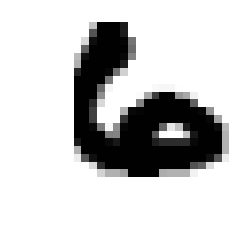

In [13]:
random.seed(50)
rand_num = random.randrange(0, len(X_tr))

rand_digit = X_tr[rand_num]

print("The chosen number that is displayed is labeled as \"{}\".\n".format(y_tr[rand_num]))

plot_digits(rand_digit)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([4132, 4684, 4177, 4351, 4072, 3795, 4137, 4401, 4063, 4188]))

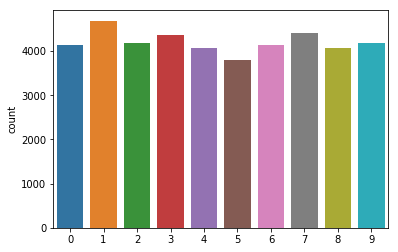

In [15]:
#Add labels and title
g = sns.countplot(y_tr[:,0])
np.unique(y_tr, return_counts=True)

0


/anaconda3/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


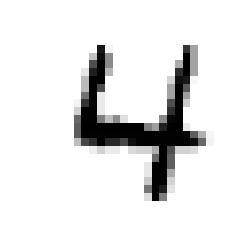

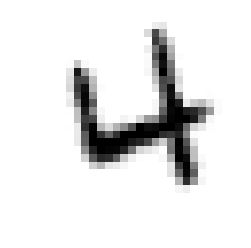

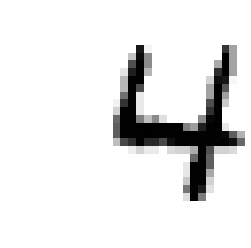

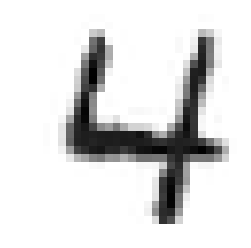

In [16]:
def shifter(img, dx, dy):
    img = img.reshape(28, 28)
    img_shift = shift(img, [dy, dx], mode="constant", cval=0)
    return img_shift.reshape([-1]) #returns 1xn array i.e. as the data is stored originally

def rotater(img, angle):
    img = img.reshape(28, 28)
    img_rotate = rotate(img, angle, reshape=False, order=1, prefilter=False)
    return img_rotate.reshape([-1])

def vert_mirror(img):
    img = img.reshape(28, 28)
    img_flip = np.fliplr(img)
    return img_flip.reshape([-1])

def add_noise(img):
    noise = np.random.randint(0, 100, (1, 784))
    return (img + noise)#/255.0

def zoomer(img, xy_zoom):
    img = img.reshape(28, 28)
    
    h, w = img.shape[:2] #28, 28
    zoom_tup = (xy_zoom, )*2 + (1, )*(img.ndim -2)
    
    zh = int(np.round(h/xy_zoom))  #23
    zw = int(np.round(w/xy_zoom)) #23
    top = (h - zh)//2  #5
    left = (w - zw)//2 #5
    
    out = zoom(img[top:top+zh, left:left+zw], zoom_tup, mode="constant")
    trim_top = ((out.shape[0]-h)//2)
    trim_left = ((out.shape[1]-w)//2)
    
    print(trim_top)
    img_zoom = out[trim_top:trim_top+h, trim_left:trim_left+w].clip(min=0)
    
    return img_zoom.reshape([-1])
    

rot_img = rotater(X_tr[42], 25)
shift_rgt = shifter(X_tr[42], 5, 0)
img_zoom = zoomer(X_tr[42], 1.2)

plot_digits(X_tr[42])
plot_digits(rot_img)
plot_digits(shift_rgt)
plot_digits(img_zoom)


In [17]:
def Data_augmentation(X, y, add_percent, add_shift=True, add_rotate=True,
                add_zoom=True):
    
    
    aug_frac = int(round(len(X_tr)*add_percent))
    X_add = X[:aug_frac]
    y_add = y[:aug_frac]

    #Random numbers:
    #spliter = StratifiedShuffleSplit(n_splits=1, train_size=add_percent,
     #                                    random_state=42)

    
    #for add_idx, ignore_idx in spliter.split(X, y):
    #    X_add = X[add_idx]
    #    y_add = y[add_idx]
    
    #so can ignore 0-X_add_len later
    add_len = len(X_add) 
    expect_new = add_len * ((add_shift)+(add_rotate)+(add_zoom))
    
    j = 0
 
    if add_shift:
        #Shift image up/down/left/right by 5 pixels

        for i in range(add_len): 
            rand = np.random.randint(4)
            
            if rand == 0:
                y_add = np.vstack([y_add, y_add[i]]) 
                right = shifter(X_add[i], 5, 0)
                X_add = np.vstack([X_add, right])
             
            if rand == 1:
                y_add = np.vstack([y_add, y_add[i]])
                left = shifter(X_add[i], -5, 0)
                X_add = np.vstack([X_add, left])
            
            if rand == 2:
                y_add = np.vstack([y_add, y_add[i]]) 
                up = shifter(X_add[i], 0, 5)
                X_add = np.vstack([X_add, up])
            
            if rand == 3:
                y_add = np.vstack([y_add, y_add[i]]) 
                down = shifter(X_add[i], 0, -5)
                X_add = np.vstack([X_add, down])
                
            j = j + 1
            sys.stdout.flush()
            print("\r{}%".format(100 * j // expect_new), end="")


            
    if add_rotate:
        #rotate cw/ccw by 25 & 45 degrees 
                  
        for i in range(add_len):
               
            rand = np.random.randint(4)
            
            if rand == 0:
                y_add = np.vstack([y_add, y_add[i]]) 
                ccw25 = rotater(X_add[i], 25)
                X_add = np.vstack([X_add, ccw25])
                
            if rand == 1:  
                y_add = np.vstack([y_add, y_add[i]])
                ccw45 = rotater(X_add[i], 45)
                X_add = np.vstack([X_add, ccw45])
                
            if rand == 2:    
                y_add = np.vstack([y_add, y_add[i]]) 
                cw25 = rotater(X_add[i], -25)
                X_add = np.vstack([X_add, cw25])
                
            if rand == 3:
                y_add = np.vstack([y_add, y_add[i]]) 
                cw45 = rotater(X_add[i], -45)
                X_add = np.vstack([X_add, cw45])
                  
            j = j+1
            sys.stdout.flush()
            print("\r{}%".format(100 * j // expect_new), end="")
                  
    if add_zoom:
        #20% zoom
        for i in range(add_len):
            y_add = np.vstack([y_add, y_add[i]]) 
            zoomed = zoomer(X_add[i], 1.2)
            X_add = np.vstack([X_add, zoomed])
            j = j+1 
            sys.stdout.flush()
            print("\r{}%".format(100 * j // expect_new), end="")

                       
    X = np.vstack([X, X_add[add_len:]])
    y = np.vstack([y, y_add[add_len:]])
    
    shuffle_index = np.random.permutation(len(X))
    X_Aug, y_Aug = X[shuffle_index], y[shuffle_index]
    
    notify('Kaggle:', 'Data Augmentation Complete')    
    return X_Aug, y_Aug

In [18]:
#Only run if Augmented data hasn't been made yet:

Aug_name = 'Aug_all_Train.csv'
csv_path = os.path.join(MNIST_PATH, Aug_name)

if os.path.isfile(csv_path):
    Aug_train = get_MNIST_data(Aug_name)
    print('file exists')
else:
    #print('file doesn\'t exists, making .csv')
    X_new, y_new = Data_augmentation(X_tr/255, y_tr, add_percent=1)
    XX = np.hstack((y_new, X_new))
    Aug_data = pd.DataFrame(XX)
    Aug_data.to_csv(csv_path, index=False)
    notify('Kaggle:', 'Data Augmentation csv creation Complete') 
    Aug_train = get_MNIST_data(Aug_name)
    
Aug_train.shape

Checking if directory exists...
Directory exists
Aug_all_Train.csv file does exists...
extracting Aug_all_Train.csv

Success!
file exists


(168000, 785)

In [19]:
X_tr = Aug_train.iloc[:, 1:].values
y_tr = Aug_train.iloc[:, :1].values

print("Augmented Training set:\t{} elements".format(len(X_tr)))

Augmented Training set:	168000 elements


In [20]:
spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in spliter.split(X_tr, y_tr):
    X_train = X_tr[train_idx]
    y_train = y_tr[train_idx]
    
    X_val = X_tr[val_idx]
    y_val = y_tr[val_idx]


print("Training set:\t{} elements\nValidation set:\t{} elements".format(len(X_train),len(X_val)))

Training set:	134400 elements
Validation set:	33600 elements


In [21]:
#Reshape Data:
X_train = X_train.astype(np.float32).reshape(-1, 28*28)#/255.0
y_train = y_train.astype(np.int32).reshape(len(y_train), )

X_val = X_val.astype(np.float32).reshape(-1, 28*28)#/255.0
y_val = y_val.astype(np.int32).reshape(len(y_val), )

test = test.astype(np.float32).reshape(-1, 28*28)#/255.0

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([16528, 18736, 16708, 17404, 16288, 15180, 16548, 17604, 16252,
        16752]))

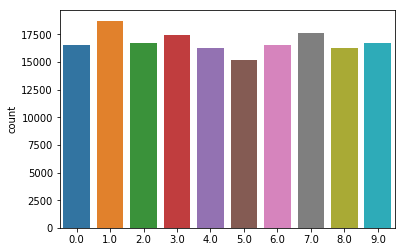

In [22]:
#Add labels and title
g = sns.countplot(y_tr[:,0])
np.unique(y_tr, return_counts=True)

# Convolutional Neural Network's Functions:

In [ ]:
#Training batches:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X)) #stratified
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

#Get model parameters:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

#Retreive model parameters:
def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)
    
    

# Convolutional Neural Network 1:

In [ ]:
#CNN Layers: 
n_inputs = 28*28

#conv layer 1:
conv1_fmaps = 32
conv1_ksize = 5
conv1_stride = 1
conv1_pad = "SAME"

#pooling layer 1:
pool1_fmaps = conv1_fmaps
pool1_ksize = 2
pool1_stride = 2
pool1_pad = "SAME"

#conv layer 2:
conv2_fmaps = 32#64
conv2_ksize = 5
conv2_stride = 1
conv2_pad = "SAME"


#pooling layer 2:
pool2_fmaps = conv1_fmaps
pool2_ksize = 2
pool2_stride = 2
pool2_pad = "SAME"
pool2_dropout_rate = 0.25

n_fc1 = 128
fc1_dropout_rate = 0.5

n_outputs = 10

In [ ]:
#Make CNN Graph:
reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, 28, 28, 1])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

#output is 28x28*32
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")

#output is 14x14*32
pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], 
                       padding=pool1_pad, name="pool1")

#output is 14x14*64
conv2 = tf.layers.conv2d(pool1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

#output is 7*7*64 -> 
with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_flat = tf.reshape(pool2, shape=[-1, conv2_fmaps * 7 * 7])
    pool2_flat_drop = tf.layers.dropout(pool2_flat, pool2_dropout_rate, training=training)

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool2_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [ ]:
#Reshape Data:
X_train = X_train.astype(np.float32).reshape(-1, 28*28)
y_train = y_train.astype(np.int32).reshape(len(y_train), )

X_val = X_val.astype(np.float32).reshape(-1, 28*28)
y_val = y_val.astype(np.int32).reshape(len(y_val), )

test = test.astype(np.float32).reshape(-1, 28*28)

In [ ]:
#Training batches:

#----------------------------------change to stratified
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X)) #stratified
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

#Get model parameters:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

#Retreive model parameters:
def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)
    
    

In [ ]:
n_epochs = 1000
batch_size = 50
iteration = 0

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            iteration += 1
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: X_val, y: y_val})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
        print("Epoch {}, last batch accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_batch * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
        
        
    #insert Test prediciton:    
    acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
    print("Final accuracy on Validation set:", acc_val)
    notify("MNIST_Kaggle", "Completed Submission of CNN")
    save_path = saver.save(sess, "./my_mnist_cnn_model")
    
    

In [ ]:
with tf.Session() as tfs:
    saver.restore(tfs, "./my_mnist_cnn_model")
    
    pred = logits.eval(feed_dict={X: test})
    prediction = np.argmax(pred, 1)
    
    create_submission(prediction, "Submission_")
    notify("MNIST_Kaggle", "Completed Submission of CNN")

#  Convolutional Neural Network 2:
based off:
https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

In [ ]:
#CNN Layers: 
n_inputs = 28*28

#conv layer 1/2:
conv1_fmaps = 32
conv1_ksize = 5
conv1_stride = 1
conv1_pad = "SAME"

#pooling layer 1:
pool1_fmaps = conv1_fmaps
pool1_ksize = 2
pool1_stride = 2
pool1_pad = "SAME"
pool1_dropout_rate = 0.4

#conv layer 3/4:
conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"


#pooling layer 2:
pool2_fmaps = conv1_fmaps
pool2_ksize = 2
pool2_stride = 2
pool2_pad = "SAME"
pool2_dropout_rate = 0.4

n_fc1 = 256
fc1_dropout_rate = 0.5

n_outputs = 10

In [ ]:
#Make CNN Graph:
reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, 28, 28, 1])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

#output is 28x28*32
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")

#output is 28x28*32
conv2 = tf.layers.conv2d(conv1, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv2")

#output is 14x14*32
with tf.name_scope("pool1"):
    pool1 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], 
                           padding=pool1_pad, name="pool1")
    pool1_drop = tf.layers.dropout(pool1, pool1_dropout_rate, training=training)

#output is 14x14*64
conv3 = tf.layers.conv2d(pool1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv3")

#output is 14x14*64
conv4 = tf.layers.conv2d(conv3, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv4")


#output is 7*7*64 -> 
with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_flat = tf.reshape(pool2, shape=[-1, conv2_fmaps * 7 * 7])
    pool2_flat_drop = tf.layers.dropout(pool2_flat, pool2_dropout_rate, training=training)

    
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool2_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [ ]:
n_epochs = 1000
batch_size = 64
iteration = 0

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 50
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            iteration += 1
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: X_val, y: y_val})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
        print("Epoch {}, last batch accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_batch * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
        
        
    #insert Test prediciton:    
    acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
    print("Final accuracy on Validation set:", acc_val)
    notify("MNIST_Kaggle", "Completed Submission of CNN")
    save_path = saver.save(sess, "./my_mnist_cnn2_model")
    
    

In [ ]:
with tf.Session() as tfs:
    saver.restore(tfs, "./my_mnist_cnn2_model")
    
    pred = logits.eval(feed_dict={X: test})
    prediction = np.argmax(pred, 1)
    
    create_submission(prediction, "Submission_CNN2_")
    notify("MNIST_Kaggle", "Completed Submission of CNN")

#  Convolutional Neural Network 3:
based off:
https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist


In [ ]:
#TO CHANGE

#CNN Layers: 

#inputs:
n_inputs = 28*28

#Group 1:
#----------------------
#conv layer 1/2:
conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

#conv layer 3:
conv3_fmaps = 32
conv3_ksize = 5
conv3_stride = 2
conv3_pad = "SAME"

#Dropout Layer:
G1_dropout_rate = 0.4
#----------------------


#Group 2:
#----------------------
#conv layer 4/5:
conv4_fmaps = 64
conv4_ksize = 3
conv4_stride = 1
conv4_pad = "SAME"

#conv layer 6:
conv6_fmaps = 64
conv6_ksize = 5
conv6_stride = 2
conv6_pad = "SAME"

#Dropout Layer:
G2_dropout_rate = 0.4
#----------------------

#Fully connected:
n_fc1 = 128
fc1_dropout_rate = 0.5

#Output:
n_outputs = 10

#Saving location
model_name = 'my_mnist_cnn3_model'
save_path = os.path.join(MODEL_PATH, model_name)

In [ ]:
#Make CNN Graph:
reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, 28, 28, 1])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

    
with tf.name_scope("Group_1"):
    #output is 28x28*32
    conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                             strides=conv1_stride, padding=conv1_pad,
                             activation= tf.nn.relu, name="conv1")
    

    #output is 28x28*32
    conv2 = tf.layers.conv2d(conv1, filters=conv1_fmaps, kernel_size=conv1_ksize,
                             strides=conv1_stride, padding=conv1_pad,
                             activation= tf.nn.relu, name="conv2")  
    
    
    #output is 14x14*32
    conv3 = tf.layers.conv2d(conv2, filters=conv3_fmaps, kernel_size=conv3_ksize,
                             strides=conv3_stride, padding=conv3_pad,
                             activation= tf.nn.relu, name="conv3")  
        
  
    c3_drop = tf.layers.dropout(conv3, G1_dropout_rate, training=training)
    
    
with tf.name_scope("Group_2"):
    #output is 14x14*64
    conv4 = tf.layers.conv2d(c3_drop, filters=conv4_fmaps, kernel_size=conv4_ksize,
                             strides=conv4_stride, padding=conv4_pad,
                             activation=tf.nn.relu, name="conv4")
    

    #output is 14x14*64
    conv5 = tf.layers.conv2d(conv4, filters=conv4_fmaps, kernel_size=conv4_ksize,
                             strides=conv4_stride, padding=conv4_pad,
                             activation=tf.nn.relu, name="conv5") 
    
    
    #output is 7x7*64
    conv6 = tf.layers.conv2d(conv5, filters=conv6_fmaps, kernel_size=conv6_ksize,
                             strides=conv6_stride, padding=conv6_pad,
                             activation=tf.nn.relu, name="conv6")  
        

    c6_flat = tf.reshape(conv6, shape=[-1, conv6_fmaps * 7 * 7])
    c6_drop = tf.layers.dropout(c6_flat, G2_dropout_rate, training=training)
    
    
with tf.name_scope("Fully_connected"):
    fc1 = tf.layers.dense(c6_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [ ]:
n_epochs = 1000
batch_size = 64 #change to 64 later
iteration = 0

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 30
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            iteration += 1
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: X_val, y: y_val})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
        print("Epoch: {}\tBatch accuracy: {:.4f}%\tValidation accuracy: {:.4f}%\tBest Validation Loss: {:.6f}".
              format(epoch, acc_batch*100, acc_val*100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
        
        
    #insert Test prediciton:    
    acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
    print("Final accuracy on Validation set:", acc_val)
    notify("MNIST_Kaggle", "Completed Submission of CNN")
    saved_path = saver.save(sess, save_path)

In [ ]:
with tf.Session() as tfs:
    saver.restore(tfs, save_path)
    
    pred = logits.eval(feed_dict={X: test})
    prediction = np.argmax(pred, 1)
    
    create_submission(prediction, "Submission_CNN3_")
    notify("MNIST_Kaggle", "Completed Submission of CNN")

#  Convolutional Neural Network 4:
## With Ensamble:

In [ ]:
#CNN Layers: 
n_inputs = 28*28

#conv layer 1/2:
conv1_fmaps = 32
conv1_ksize = 5
conv1_stride = 1
conv1_pad = "SAME"

#pooling layer 1:
pool1_fmaps = conv1_fmaps
pool1_ksize = 2
pool1_stride = 2
pool1_pad = "SAME"
pool1_dropout_rate = 0.4

#conv layer 3/4:
conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"


#pooling layer 2:
pool2_fmaps = conv2_fmaps
pool2_ksize = 2
pool2_stride = 2
pool2_pad = "SAME"
pool2_dropout_rate = 0.4

n_fc1 = 256
fc1_dropout_rate = 0.5

n_outputs = 10

#Saving location
model_name = 'Ensamble/my_mnist_cnn_ensamble_'
save_path = os.path.join(MODEL_PATH, model_name)

In [ ]:
#Based on: https://www.kaggle.com/elcaiseri/mnist-with-accuracy-0-999

#Make CNN Graph:
reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, 28, 28, 1])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

#output is 28x28*32
conv1 = tf.layers.conv2d(X_reshaped, filters=64, kernel_size=3,
                         strides=1, padding="SAME",
                         activation=tf.nn.relu, name="conv1")

#output is 28x28*32
conv2 = tf.layers.conv2d(conv1, filters=64, kernel_size=3,
                         strides=1, padding="SAME",
                         activation=tf.nn.relu, name="conv2")

#output is 14x14*32
with tf.name_scope("pool1"):
    pool1 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], 
                           padding="SAME", name="pool1")
    pool1_drop = tf.layers.dropout(pool1, pool1_dropout_rate, training=training)
    


#output is 14x14*64
conv3 = tf.layers.conv2d(pool1, filters=128, kernel_size=3,
                         strides=1, padding="SAME",
                         activation=tf.nn.relu, name="conv3")

#output is 14x14*64
conv4 = tf.layers.conv2d(conv3, filters=128, kernel_size=3,
                         strides=1, padding="SAME",
                         activation=tf.nn.relu, name="conv4")

#output is 14x14*32
with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], 
                           padding="SAME", name="pool1")
    pool2_drop = tf.layers.dropout(pool2, pool1_dropout_rate, training=training)
    
    
#output is 14x14*64
conv5 = tf.layers.conv2d(pool2, filters=256, kernel_size=3,
                         strides=1, padding="SAME",
                         activation=tf.nn.relu, name="conv5")

#output is 7*7*64 -> 
with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, 256 * 3 * 3])
    pool3_flat_drop = tf.layers.dropout(pool3_flat, pool2_dropout_rate, training=training)

    
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [ ]:
#Make CNN Graph:
reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, 28, 28, 1])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

#output is 28x28*32
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")

#output is 28x28*32
conv2 = tf.layers.conv2d(conv1, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv2")

#output is 14x14*32
with tf.name_scope("pool1"):
    pool1 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], 
                           padding=pool1_pad, name="pool1")
    pool1_drop = tf.layers.dropout(pool1, pool1_dropout_rate, training=training)

#output is 14x14*64
conv3 = tf.layers.conv2d(pool1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv3")

#output is 14x14*64
conv4 = tf.layers.conv2d(conv3, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv4")


#output is 7*7*64 -> 
with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_flat = tf.reshape(pool2, shape=[-1, conv2_fmaps * 7 * 7])
    pool2_flat_drop = tf.layers.dropout(pool2_flat, pool2_dropout_rate, training=training)

    
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool2_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [ ]:
n_epochs = 5
batch_size = 64
check_interval = 500
max_checks_without_progress = 20
ensable_num = 10

for cnn_num in range(ensable_num):
    iteration = 0
    best_loss_val = np.infty
    checks_since_last_progress = 0
    best_model_params = None 

    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
                iteration += 1
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
                if iteration % check_interval == 0:
                    loss_val = loss.eval(feed_dict={X: X_val, y: y_val})
                    if loss_val < best_loss_val:
                        best_loss_val = loss_val
                        checks_since_last_progress = 0
                        best_model_params = get_model_params()
                    else:
                        checks_since_last_progress += 1
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
            print("Epoch {}, last batch accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                      epoch, acc_batch * 100, acc_val * 100, best_loss_val))
            if checks_since_last_progress > max_checks_without_progress:
                print("Early stopping!")
                break

        if best_model_params:
            restore_model_params(best_model_params)
        
        print('Done with CNN_'+str(cnn_num))
        
        #insert Test prediciton:    
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
        print("Final accuracy on Validation set:", acc_val)
        msg = "Completed training of CNN_4_"+str(cnn_num)
        notify("MNIST_Kaggle", msg)
        
        en_name = model_name + str(cnn_num+10)
        en_save = os.path.join(MODEL_PATH, en_name)
        save_path = saver.save(sess, en_save)
        
notify("MNIST_Kaggle", "Completed Ensamble Training!!!")    

In [ ]:
#Saving location
model_name = 'Ensamble/my_mnist_cnn_ensamble_'
save_path = os.path.join(MODEL_PATH, model_name)

#Ensamble Predictions:
lables = []

for cnn in range(ensable_num):
     with tf.Session() as tfs:
            en_name = model_name + str(cnn)
            en_save = os.path.join(MODEL_PATH, en_name)        
            saver.restore(tfs, en_save)
            pred = logits.eval(feed_dict={X: test})
            lables.append(pred)

        
ens_label = np.mean(lables, axis=0)
prediction = np.argmax(ens_label, 1)
create_submission(prediction, "Submission_Ens_")
notify("MNIST_Kaggle", "Completed Submission of CNN")